In [8]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("XLSX")
Pkg.add("CSV")


  Activating project at `~/Desktop/BEE 4750/BEE4750FinalProject-1`
   Resolving package versions...
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Project.toml`
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Project.toml`
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Manifest.toml`


In [9]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables
using XLSX
using CSV

Load Data for all buildings

In [ ]:
# Read the CSV file into a DataFrame
df = CSV.read("CascadillaHall.csv", DataFrame)
date = df."Date"[1:366]
casc_steam = df."Steam (lbs/hr)"[1:366]
casc_electric = df."Electric (kW)"[1:366]

df = CSV.read("HuShihHall.csv", DataFrame)
hushih_chilled_water = df."Chilled Water (tons)"[1:366]
hushih_hot_water = df."Hot Water (kBTU/hr)"[1:366]
hushih_electric = df."Electric (kW)"[1:366]

df = CSV.read("UrisLibrary.csv", DataFrame)
uris_chilled_water = df."Chilled Water (ons)"[1:366]
uris_electric = df."Electric (kW)"[1:366]
uris_steam = df."Steam (lbs/hr)"[1:366]




ArgumentError: ArgumentError: column name "Chilled Water (tons)" not found in the data frame; existing most similar names are: "Chilled Water (Tons)"

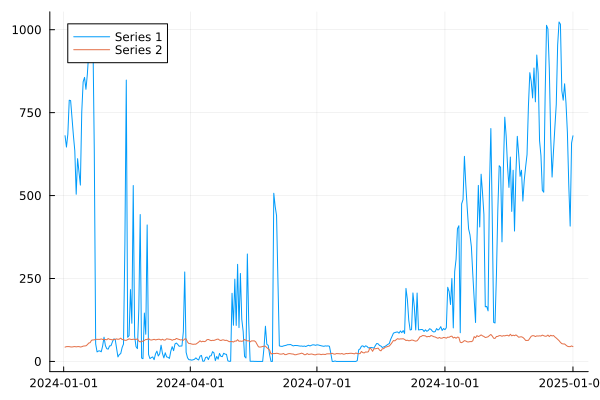

In [12]:
# Cascadilla plots
p = plot(date, casc_steam, label="Series 1")
plot!(p, date, casc_electric, label="Series 2")
display(p)

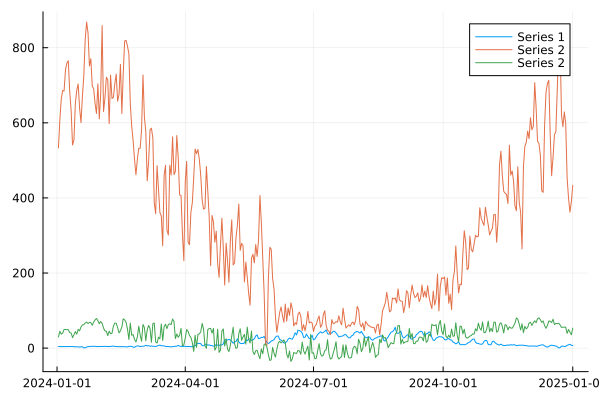

In [11]:
# Hu Shih Plots
p = plot(date, hushih_chilled_water, label="Series 1")
plot!(p, date, hushih_hot_water, label="Series 2")
plot!(p, date, hushih_electric, label="Series 2")
display(p)

In [ ]:
# Uris Library Plots
p = plot(date, uris_chilled_water, label="Series 1")
plot!(p, date, uris_electric, label="Series 2")
plot!(p, date, uris_steam, label="Series 2")
display(p)